In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import numpy as np

In [72]:
from sklearn.base import clone

In [3]:
boston = load_boston()
# House Prices
y = boston.target
# The other 13 features
X = boston.data

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 103)

In [100]:
rf = RandomForestRegressor(n_estimators=100,
                            n_jobs=-1,
                            random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(),
                         learning_rate=0.1,
                         loss='linear',
                         n_estimators=100,
                         random_state=1)
estimators = [rf,gdbr,abr]

In [50]:
#np.mean(cross_val_score(rf,X_train,y_train, cv = 3,
#                scoring=make_scorer(mean_squared_error)))
gdbr.n_estimators

100

In [101]:
def cv_train_comparison(X,y,estimators):  
    for est in estimators:
        #est2 =clone(est)
        mse = np.mean(cross_val_score(est,X,y, cv = 3,
                scoring=make_scorer(mean_squared_error)))
        r2 = np.mean(cross_val_score(est,X,y, cv = 3,
                scoring=make_scorer(r2_score)))
        print("{:28} Train CV | MSE: {:2.2f}  R2: {:.3f}".format(type(est).__name__,mse,r2))

In [104]:
np.mean(cross_val_score(rf,X_train,y_train, cv = 3,
                scoring=make_scorer(mean_squared_error)))

11.618359727639579

In [102]:
cv_train_comparison(X_train,y_train, estimators)

RandomForestRegressor        Train CV | MSE: 11.62  R2: 0.859
GradientBoostingRegressor    Train CV | MSE: 10.37  R2: 0.874
AdaBoostRegressor            Train CV | MSE: 12.01  R2: 0.854


In [82]:
gdbr2 = GradientBoostingRegressor(learning_rate=1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)
estimators.append(gdbr2)

In [83]:
cv_train_comparison(X_train,y_train, estimators)

RandomForestRegressor        Train CV | MSE: 11.62  R2: 0.859
GradientBoostingRegressor    Train CV | MSE: 10.37  R2: 0.874
AdaBoostRegressor            Train CV | MSE: 12.01  R2: 0.854
GradientBoostingRegressor    Train CV | MSE: 27.36  R2: 0.669
GradientBoostingRegressor    Train CV | MSE: 27.36  R2: 0.669


In [60]:
def stage_score_plot(estimator, X_train, y_train, X_test, y_test):
    '''
    Parameters: estimator: GradientBoostingRegressor or AdaBoostRegressor
                X_train: 2d numpy array
                y_train: 1d numpy array
                X_test: 2d numpy array
                y_test: 1d numpy array

    Returns: A plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    mse_train = np.zeros(estimator.n_estimators)
    mse_test = np.zeros(estimator.n_estimators)
    estimator.fit(X_train,y_train)
    for ind, (yh_test,yh_train) in enumerate(zip(estimator.staged_predict(X_test),
                                                 estimator.staged_predict(X_train))):
        mse_test[ind]=mean_squared_error(y_test,yh_test)
        mse_train[ind]=mean_squared_error(y_train,yh_train)
    
    plt.plot(np.r_[0:estimator.n_estimators],mse_test,
             label ='{} Test Rate {}'.format(estimator.__class__.__name__, estimator.learning_rate))
    plt.plot(np.r_[0:estimator.n_estimators],mse_train,
             label ='{} Train Rate {}'.format(estimator.__class__.__name__, estimator.learning_rate))
    plt.legend()

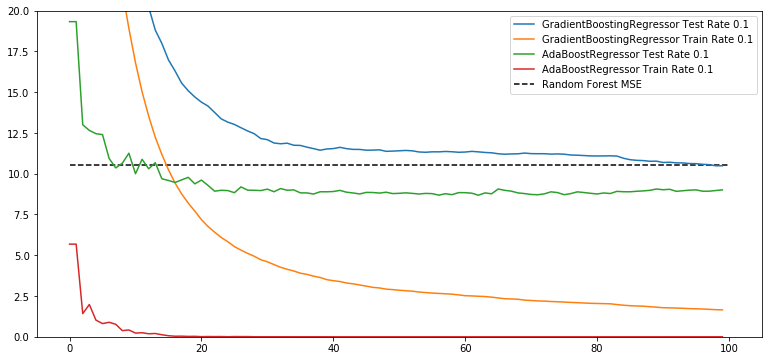

In [85]:
plt.figure(figsize=(13,6))
plt.axis(ymax = 20)
stage_score_plot(gdbr, X_train, y_train, X_test, y_test)
stage_score_plot(abr, X_train, y_train, X_test, y_test)
rf.fit(X_train,y_train)
plt.hlines(mean_squared_error(y_test, rf.predict(X_test)),0,100,linestyles='--', label = 'Random Forest MSE')
plt.legend()
plt.show()

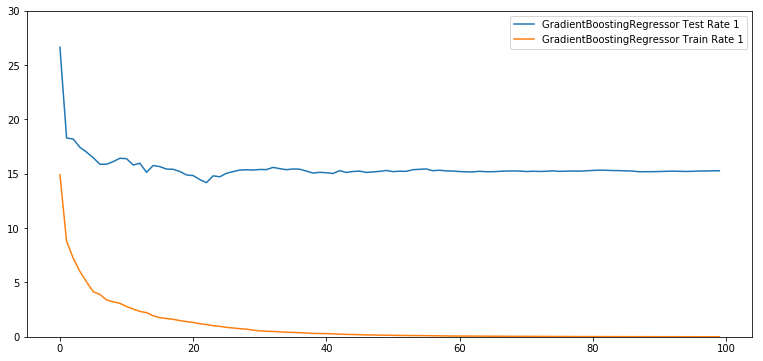

In [86]:
plt.figure(figsize=(13,6))
plt.axis(ymax = 30)
stage_score_plot(gdbr2, X_train, y_train, X_test, y_test)

In [87]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)

print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   14.7s


best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'random_state': 1}


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   16.2s finished
/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [89]:
best_rf_model.fit(X_train,y_train)
print(mean_squared_error(y_test, rf.predict(X_test)))
print(mean_squared_error(y_test, best_rf_model.predict(X_test)))

10.526030333333344
9.916258088235296


In [91]:
gb_grid = {'learning_rate':[0.01,0.1,0.4],
          'max_depth':[None,1,5],
          'min_samples_leaf':[1,5],
          'n_estimators':[100,1000,3000],
          'max_features':[None,3]}
gb_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gb_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
gb_gridsearch.fit(X_train, y_train)

print( "best parameters:", gb_gridsearch.best_params_ )

best_gb_model = gb_gridsearch.best_estimator_

best_gb_model.fit(X_train,y_train)
print(mean_squared_error(y_test, gdbr.predict(X_test)))
print(mean_squared_error(y_test, best_gb_model.predict(X_test)))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   22.5s finished
/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 1000}
10.48631075801014
8.578908219078112


In [98]:
gb_grid = {'learning_rate':[0.002,0.005,0.01],
          'max_depth':[None,5,7],
          'min_samples_leaf':[1,3,4],
          'n_estimators':[1000,3000,5000],
          'max_features':[None,3]}

gb_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gb_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
gb_gridsearch.fit(X_train, y_train)

print( "best parameters:", gb_gridsearch.best_params_ )

best_gb_model = gb_gridsearch.best_estimator_

best_gb_model.fit(X_train,y_train)
print(mean_squared_error(y_test, gdbr.predict(X_test)))
print(mean_squared_error(y_test, best_gb_model.predict(X_test)))

/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 162 candidates, totalling 486 fits


/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  2.5min finished
/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 3000}
10.48631075801014
8.085686465521839


In [110]:
ad_grid = {'learning_rate':[0.05,0.1,0.4,0.9,1],
          'base_estimator':[DecisionTreeRegressor(max_depth=7),DecisionTreeRegressor(max_depth=13),DecisionTreeRegressor(max_depth=15),DecisionTreeRegressor(max_depth=9)],
          'n_estimators':[50,100,150,200]}
ad_gridsearch = GridSearchCV(AdaBoostRegressor(),
                             ad_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error',
                            cv = 8)
ad_gridsearch.fit(X_train, y_train)

print( "best parameters:", ad_gridsearch.best_params_ )

best_ad_model = ad_gridsearch.best_estimator_
abr.fit(X_train,y_train)
best_ad_model.fit(X_train,y_train)
print(mean_squared_error(y_test, abr.predict(X_test)))
print(mean_squared_error(y_test, best_ad_model.predict(X_test)))

Fitting 8 folds for each of 80 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   32.5s finished
/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'), 'learning_rate': 0.9, 'n_estimators': 150}
9.00892156862745
8.637961477800994
